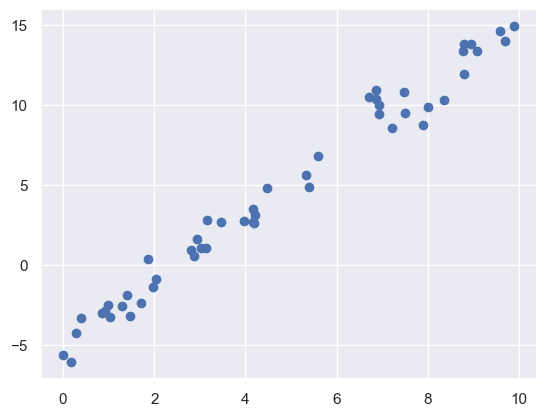

In [1]:
#In Depth: Linear Regression

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

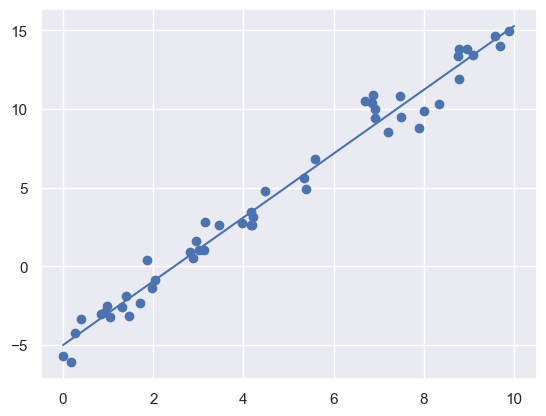

In [2]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit);

In [3]:
print("Model slope: ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:  2.0272088103606944
Model intercept: -4.9985770855532


In [4]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])
model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.500000000000014
[ 1.5 -2.   1. ]


In [5]:
# Basis Function Regression

from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

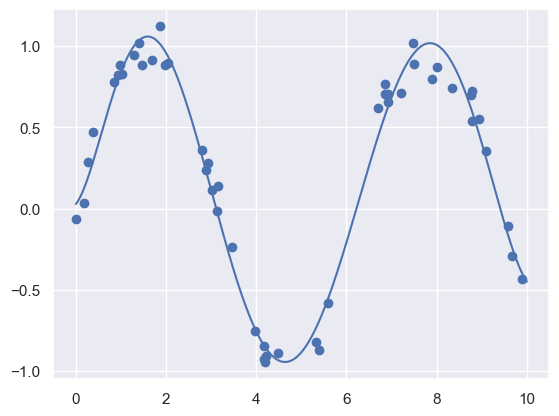

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
LinearRegression())

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit);

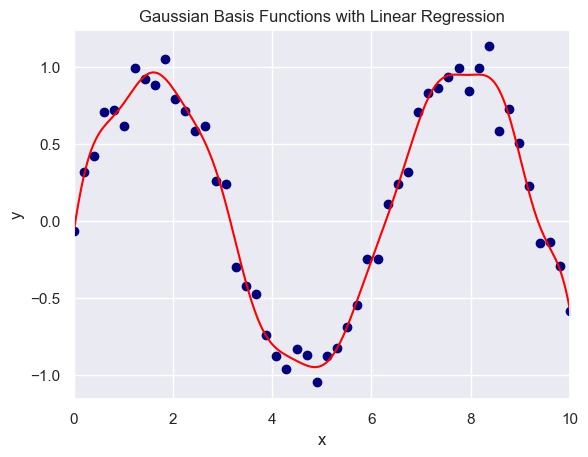

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# Gaussian basis function transformer
class GaussianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y=None):
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

# Dummy data
x = np.linspace(0, 10, 50)
y = np.sin(x) + 0.1 * np.random.randn(50)
xfit = np.linspace(0, 10, 1000)

# Create pipeline (IMPORTANT: do this outside the class!)
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())

# Fit and predict
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

# Plot
plt.scatter(x, y, color='navy')
plt.plot(xfit, yfit, color='red')
plt.xlim(0, 10)
plt.title("Gaussian Basis Functions with Linear Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


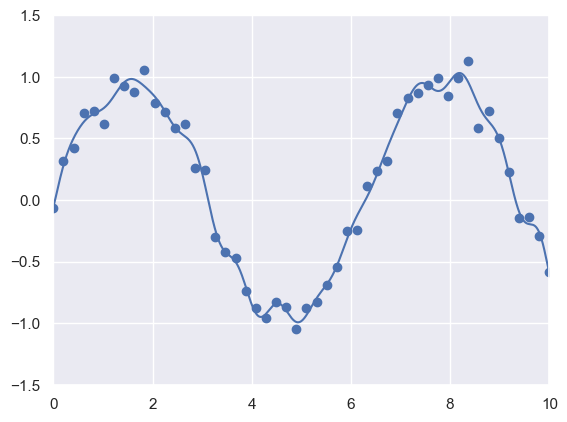

In [14]:
#Regularization

model = make_pipeline(GaussianFeatures(30),
LinearRegression())
model.fit(x[:, np.newaxis], y)
plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

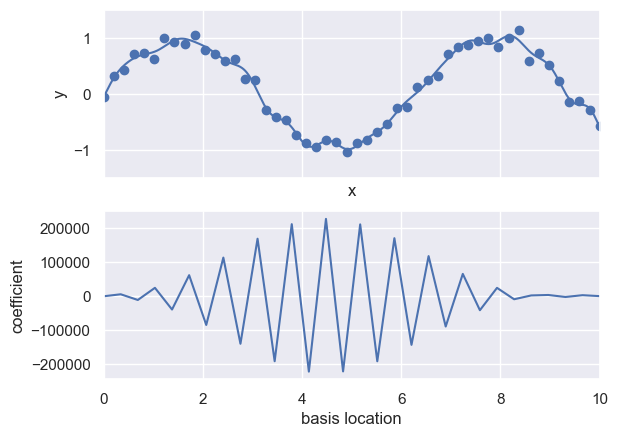

In [18]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_,
    model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
    ylabel='coefficient',
    xlim=(0, 10))
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

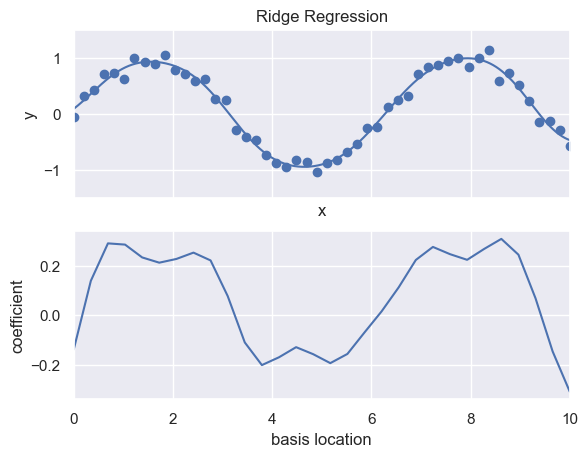

In [19]:
#Ridge regression (L2 regularization)

from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

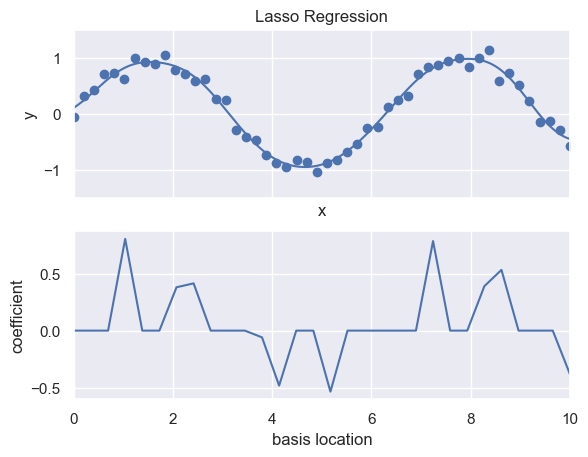

In [20]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

In [24]:
#Example: Predicting Bicycle Traic

import pandas as pd
counts = pd.read_csv('fremont_hourly.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('599021.csv', index_col='DATE', parse_dates=True)

daily = counts.resample('d', how='sum')
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

def hours_of_daylight(date, axis=23.44, latitude=47.61):
#"""Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
    * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot();

# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

daily['annual'] = (daily.index - daily.index[0]).days / 365.
daily.head()



FileNotFoundError: [Errno 2] No such file or directory: 'fremont_hourly.csv'

In [25]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

daily[['Total', 'predicted']].plot(alpha=0.5);

NameError: name 'daily' is not defined

In [26]:
params = pd.Series(model.coef_, index=X.columns)
params

AttributeError: 'Pipeline' object has no attribute 'coef_'

In [27]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
for i in range(1000)], 0)

ValueError: Found input variables with inconsistent numbers of samples: [100, 50]

In [28]:
print(pd.DataFrame({'effect': params.round(0),
'error': err.round(0)}))

NameError: name 'params' is not defined